In [2]:
%load_ext autoreload
%autoreload 2

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import os
from edca_analysis.sdca_gaussian_exogenous import SupervisedDCA as SDCAe
import pickle
from scipy.stats import boxcox

from edca_analysis.plot_utils import axplot_imshow, append_marginal_axis
from edca_analysis.analysis import calculate_leverage_score

In [4]:
DATA_DIR = "../OFC_data/"
IMG_DIR = "./images/EC125"
os.makedirs(IMG_DIR, exist_ok=True)
fn = "v7_EC125_TimeAveragedSpectraPower_6mA_FreqBands.pkl"
patient = fn.split("_")[1]
current = [i for i in fn.split("_") if "mA" in i][0]
savefig = False
patient, current

('EC125', '6mA')

In [5]:
with open(f"{DATA_DIR}/{fn}", "rb") as f:
    data_dict = np.load(f, allow_pickle=True).item()

In [6]:
power = data_dict["power_stim"]
freqs = data_dict["freqs"]
finalVerifiedChanNames = data_dict["finalVerifiedChanNames"]
finalVerifiedRegions = data_dict["finalVerifiedRegions"]
regionNames = data_dict["regionNames"]

print(power.shape)
cutoff_freq = 28
cutoff_idx = np.where(freqs > cutoff_freq)[0][0]
power = power[:, :cutoff_idx]
print(cutoff_idx)
freqs = freqs[:cutoff_idx]
print(power.shape)

(17, 31, 224964)
20
(17, 20, 224964)


In [7]:
finalVerifiedChanNames, finalVerifiedRegions, regionNames

(array(['AOF1', 'AOF4', 'POF2', 'AD2', 'AD3', 'AD4', 'HD2', 'HD3', 'SC3',
        'SC4', 'IC2', 'IC3', 'IND1', 'IND2', 'IND3', 'IND4', 'IND5'],
       dtype='<U4'),
 array([1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 6, 6, 6], dtype=uint8),
 array(['OFC', 'Amygdala', 'Hippocampus', 'SuperiorCingulate',
        'InferiorCingulate', 'Insula'], dtype='<U17'))

In [8]:
Fs = data_dict["Fs"]
dsFs = data_dict["dsFs"]
# stim_start = int(np.floor(int(1.0 * data_dict["stimStartSample"]) * dsFs / Fs))
# stim_end = int(np.floor(int(1.0 * data_dict["stimEndSample"]) * dsFs / Fs))

stim_start = int(1.0 * data_dict["stimStartSample"])
stim_end = int(1.0 * data_dict["stimEndSample"])

print(stim_start, stim_end)
print(stim_start / dsFs, stim_end / dsFs)

12972 131088
25.3359375 256.03125


In [9]:
region = "OFC"
region_idx = np.where(np.array(regionNames) == region)[0][0] + 1
chan_idx = np.where(np.array(finalVerifiedRegions) == region_idx)[0]
chan_idx, region_idx

(array([0, 1, 2]), 1)

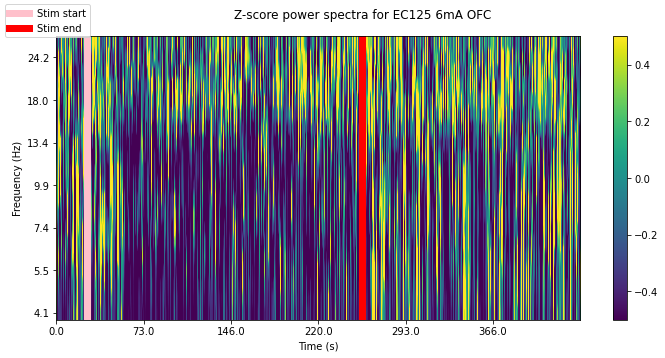

In [103]:
fig, ax = plt.subplots(figsize=(10, 5))
# this is spectrogram of one electrode (or averaged), dimensions (freq, time)
plt_data = np.mean(power[chan_idx], axis=0)  # average over electrodes in OFC
# plt_data = power[0]  # one electrode in OFC

# take z-score of power spectra before stim
plt_data = (
    plt_data - np.mean(plt_data[:, :stim_start], axis=1, keepdims=True)
) / np.std(plt_data[:, :stim_start], axis=1, keepdims=True)

im = ax.imshow(
    plt_data, aspect="auto", cmap="viridis", vmin=-0.5, vmax=0.5
)  # plot lower frequency at bottom
ax.axvline(stim_start, color="pink", lw=7, label="Stim start")
ax.axvline(stim_end, color="red", lw=7, label="Stim end")
fig.colorbar(im, ax=ax)
ax.invert_yaxis()
y_steps = 6
chosen_indices = np.arange(0, len(power[0]))[:: len(power[0]) // (y_steps)]
ax.set_yticks(chosen_indices)
ax.set_yticklabels(np.round([freqs[i] for i in chosen_indices], 1))
time_steps = 6
time_indices = np.arange(0, len(plt_data[0]))[:: len(plt_data[0]) // (time_steps)]
ax.set_xticks(time_indices)
ax.set_xticklabels(np.round([i / dsFs for i in time_indices]))
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
# ax.set_title(f"{finalVerifiedChanNames[0]}")

title = f"Z-score power spectra for {patient} {current} {region}"
fig.suptitle(f"{title}")
fig.legend(loc="upper left")
fig.tight_layout()
savefig = False
if savefig:
    fig.savefig(f"{IMG_DIR}/{title}.png", facecolor="white", transparent=False, dpi=300)

Making sure I am combining all the electrodes within each region so it is  
[(electrode 1, frequency 1), (electrode 2, frequency 1), ..., (electrode n, frequency 1),  
 (electrode 1, frequency 2), (electrode 2, frequency 2), ..., (electrode n, frequency 2),  
 ...  
 (electrode 1, frequency j), (electrode 2, frequency j), ..., (electrode n, frequency j)]

In [20]:
a = np.tile(np.arange(0, 10).reshape(2, 5), (3, 1, 1))
a, a.shape

(array([[[0, 1, 2, 3, 4],
         [5, 6, 7, 8, 9]],
 
        [[0, 1, 2, 3, 4],
         [5, 6, 7, 8, 9]],
 
        [[0, 1, 2, 3, 4],
         [5, 6, 7, 8, 9]]]),
 (3, 2, 5))

In [29]:
np.stack(a, axis=1).reshape(-1, a.shape[-1])

array([[0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [5, 6, 7, 8, 9],
       [5, 6, 7, 8, 9],
       [5, 6, 7, 8, 9]])

In [49]:
curr_pow = power[chan_idx]
print(curr_pow.shape)
curr_pow = np.stack(curr_pow, axis=1).reshape(-1, curr_pow.shape[-1])
print(curr_pow.shape)
np.sum(curr_pow[3] - power[chan_idx[0]][1])

(3, 20, 224964)
(60, 224964)


0.0

In [51]:
# curr_pow = np.mean(power[chan_idx], axis=0)
curr_pow = power[chan_idx]
curr_pow = np.stack(curr_pow, axis=1).reshape(-1, curr_pow.shape[-1])
transformed = [boxcox(curr_power[:stim_start]) for curr_power in curr_pow]
boxcox_lambda = [second for (first, second) in transformed]
np.round(boxcox_lambda, 3)

array([0.109, 0.027, 0.109, 0.139, 0.033, 0.16 , 0.181, 0.033, 0.176,
       0.207, 0.088, 0.167, 0.261, 0.147, 0.151, 0.245, 0.13 , 0.152,
       0.17 , 0.152, 0.162, 0.219, 0.137, 0.153, 0.217, 0.175, 0.17 ,
       0.212, 0.156, 0.202, 0.185, 0.104, 0.212, 0.165, 0.139, 0.208,
       0.239, 0.161, 0.239, 0.198, 0.209, 0.277, 0.218, 0.184, 0.258,
       0.23 , 0.199, 0.261, 0.249, 0.221, 0.258, 0.246, 0.196, 0.255,
       0.244, 0.237, 0.204, 0.222, 0.245, 0.188])

In [52]:
data = np.array(
    [
        boxcox(curr_power, lmbda=boxcox_lambda[i])
        for i, curr_power in enumerate(curr_pow)
    ]
)

In [53]:
data = (data - np.mean(data[:, :stim_start], axis=1, keepdims=True)) / np.std(
    data[:, :stim_start], axis=1, keepdims=True
)
data = data.T
print(data.shape)

(224964, 60)


## Region 2

In [61]:
region2 = "Insula"
region2_idx = np.where(np.array(regionNames) == region2)[0][0] + 1
chan2_idx = np.where(np.array(finalVerifiedRegions) == region2_idx)[0]
chan2_idx, region2_idx

(array([12, 13, 14, 15, 16]), 6)

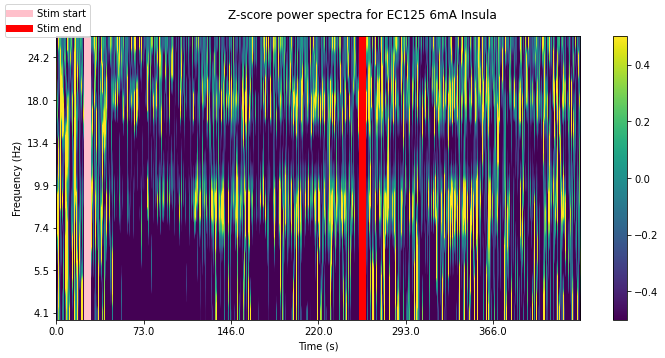

In [104]:
fig, ax = plt.subplots(figsize=(10, 5))
# this is spectrogram of one electrode (or averaged), dimensions (freq, time)
plt_data = np.mean(power[chan2_idx], axis=0)  # average over electrodes in OFC
# plt_data = power[0]  # one electrode in OFC

# take z-score of power spectra before stim
plt_data = (
    plt_data - np.mean(plt_data[:, :stim_start], axis=1, keepdims=True)
) / np.std(plt_data[:, :stim_start], axis=1, keepdims=True)

im = ax.imshow(
    plt_data, aspect="auto", cmap="viridis", vmin=-0.5, vmax=0.5
)  # plot lower frequency at bottom
ax.axvline(stim_start, color="pink", lw=7, label="Stim start")
ax.axvline(stim_end, color="red", lw=7, label="Stim end")
fig.colorbar(im, ax=ax)
ax.invert_yaxis()
y_steps = 6
chosen_indices = np.arange(0, len(power[0]))[:: len(power[0]) // (y_steps)]
ax.set_yticks(chosen_indices)
ax.set_yticklabels(np.round([freqs[i] for i in chosen_indices], 1))
time_steps = 6
time_indices = np.arange(0, len(plt_data[0]))[:: len(plt_data[0]) // (time_steps)]
ax.set_xticks(time_indices)
ax.set_xticklabels(np.round([i / dsFs for i in time_indices]))
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
# ax.set_title(f"{finalVerifiedChanNames[0]}")

title = f"Z-score power spectra for {patient} {current} {region2}"
fig.suptitle(f"{title}")
fig.legend(loc="upper left")
fig.tight_layout()
savefig = False
if savefig:
    fig.savefig(f"{IMG_DIR}/{title}.png", facecolor="white", transparent=False, dpi=300)

In [62]:
curr_pow2 = power[chan2_idx]
curr_pow2 = np.stack(curr_pow2, axis=1).reshape(-1, curr_pow2.shape[-1])
transformed2 = [boxcox(curr_power[:stim_start]) for curr_power in curr_pow2]
boxcox_lambda = [second for (first, second) in transformed2]
np.round(boxcox_lambda, 3)

array([0.216, 0.223, 0.141, 0.206, 0.216, 0.332, 0.223, 0.156, 0.197,
       0.249, 0.369, 0.19 , 0.165, 0.28 , 0.281, 0.334, 0.172, 0.144,
       0.32 , 0.25 , 0.275, 0.225, 0.157, 0.322, 0.275, 0.275, 0.212,
       0.222, 0.274, 0.231, 0.266, 0.215, 0.189, 0.202, 0.202, 0.288,
       0.259, 0.14 , 0.167, 0.194, 0.325, 0.251, 0.177, 0.212, 0.114,
       0.264, 0.29 , 0.219, 0.214, 0.053, 0.26 , 0.282, 0.214, 0.218,
       0.084, 0.259, 0.246, 0.251, 0.187, 0.126, 0.276, 0.279, 0.242,
       0.223, 0.154, 0.273, 0.295, 0.269, 0.248, 0.216, 0.251, 0.278,
       0.242, 0.231, 0.248, 0.203, 0.294, 0.239, 0.236, 0.217, 0.251,
       0.206, 0.183, 0.216, 0.257, 0.227, 0.244, 0.225, 0.203, 0.242,
       0.196, 0.237, 0.171, 0.187, 0.258, 0.159, 0.258, 0.192, 0.221,
       0.278])

In [63]:
data2 = np.array(
    [
        boxcox(curr_power, lmbda=boxcox_lambda[i])
        for i, curr_power in enumerate(curr_pow2)
    ]
)

In [64]:
data2 = (data2 - np.mean(data2[:, :stim_start], axis=1, keepdims=True)) / np.std(
    data2[:, :stim_start], axis=1, keepdims=True
)
data2 = data2.T
print(data2.shape)

(224964, 100)


## Fit eDCA

In [65]:
def get_xdca_projections(X, U, T, d, d_exo, rng_or_seed=0):

    sdcae_model = SDCAe(d=d, d_exo=d_exo, T=T, rng_or_seed=rng_or_seed)
    sdcae_model.fit(X, U)
    V_sdcae = sdcae_model.coef_
    V_sdcae_exo = sdcae_model.coef_exogenous_

    return sdcae_model, V_sdcae, V_sdcae_exo

In [125]:
d = 3
d_exo = 5
T = 10

sdcae_model, V, V_exo = get_xdca_projections(
    data, data2, T=T, d=d, d_exo=d_exo, rng_or_seed=0
)

In [126]:
def axplot_imshow_data(
    ax,
    data,
    xmin,
    xmax,
    ymin,
    ymax,
    vmin=None,
    vmax=None,
    vmax_quantile=None,
    cmap="gray_r",
    show_ratio=0.12,
    interpolation="antialiased",
    ylabel=None,
    title=None,
):

    if vmax is None:
        if vmax_quantile is None:
            vmax = np.max(np.abs(data))
        else:
            vmax = np.quantile(np.abs(data), vmax_quantile)
    if vmin is None:
        vmin = -vmax

    im = ax.imshow(
        data.T,
        cmap=cmap,
        extent=(xmin, xmax, ymax, ymin),
        aspect=(show_ratio * (xmax - xmin) / (ymax - ymin)),
        vmin=vmin,
        vmax=vmax,
        interpolation=interpolation,
    )
    if title is not None:
        ax.set_title(title)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    ax.set_ylim((ymin, ymax))

    return im

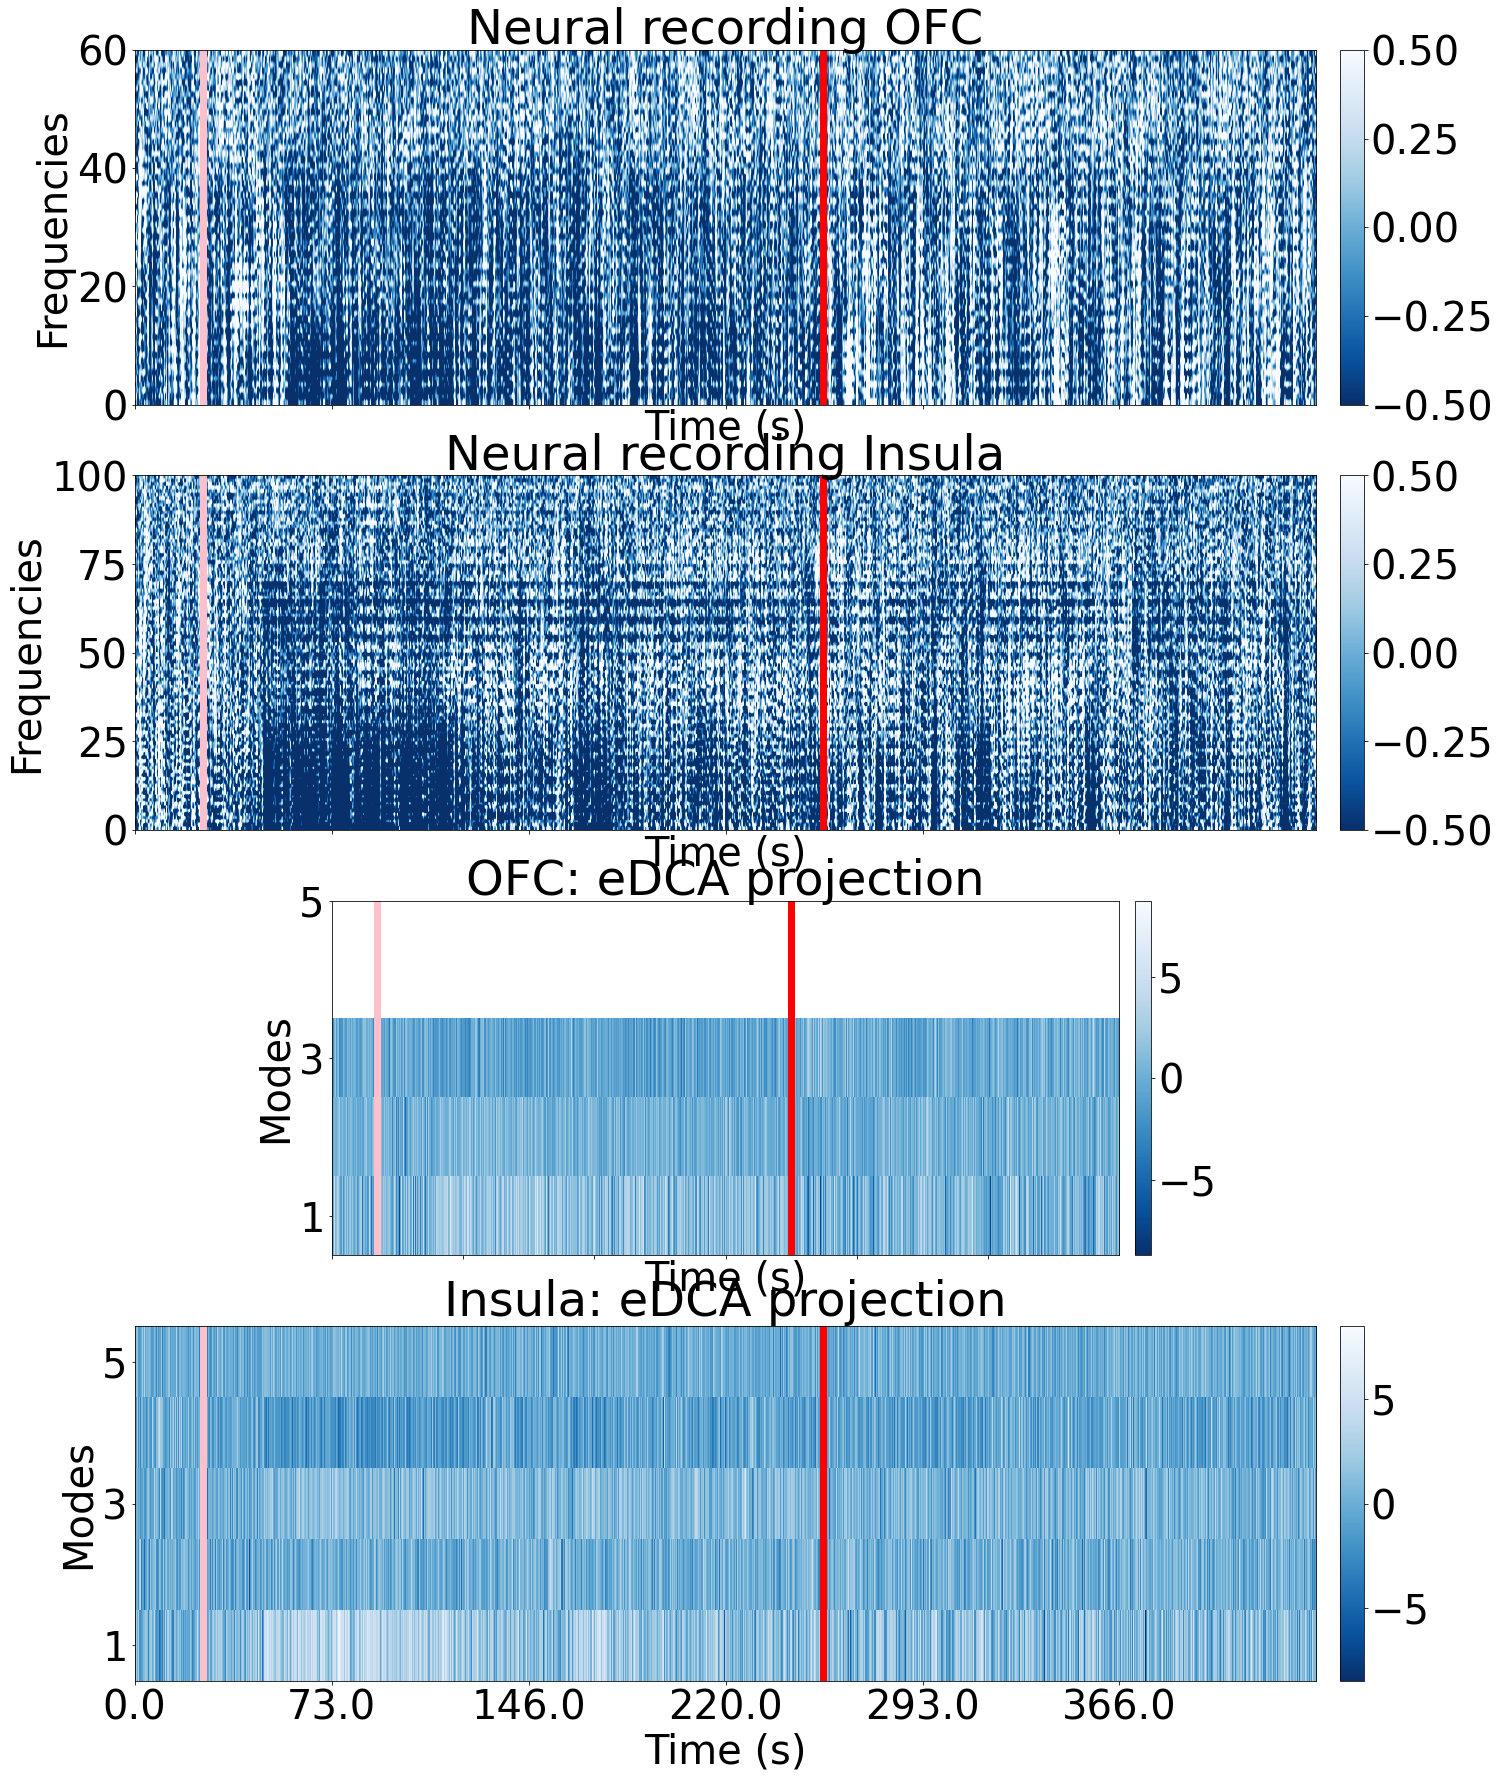

In [127]:
show_ratio = 0.3
plt.rc("font", size=40)

cb_kwargs = dict(spacing=0.02, width=0.02, which="x")

fig, axes = plt.subplots(4, 1, figsize=(30, 30), sharex=True)
# fig.subplots_adjust(top=0.3)

# --- input data ---

ax = axes[0]
im = axplot_imshow_data(
    ax,
    data,
    xmin=0,
    xmax=len(data),
    ymin=0,
    ymax=len(data[1]),
    vmin=-0.5,
    vmax=0.5,
    show_ratio=show_ratio,
    cmap="Blues_r",
    ylabel="Frequencies",
    title=f"Neural recording {region}",
)
# colorbar
cbar_ax = append_marginal_axis(ax, **cb_kwargs)
fig.colorbar(im, cax=cbar_ax)

ax = axes[1]
im = axplot_imshow_data(
    ax,
    data2,
    xmin=0,
    xmax=len(data2),
    ymin=0,
    ymax=len(data2[1]),
    show_ratio=show_ratio,
    vmin=-0.5,
    vmax=0.5,
    cmap="Blues_r",
    ylabel="Frequencies",
    # title='speech mel spectrogram',
    title=f"Neural recording {region2}",
)
# colorbar
cbar_ax = append_marginal_axis(ax, **cb_kwargs)
fig.colorbar(im, cax=cbar_ax)


# --- xDCA projections ---

V_list = [V]
titles = [f"{region}: eDCA projection"]

for ax, title, V_tmp in zip(axes[2:3], titles, V_list):
    X_proj = data @ V_tmp
    im = axplot_imshow_data(
        ax,
        X_proj,
        xmin=0,
        xmax=len(data),
        ymin=0,
        ymax=d,
        show_ratio=show_ratio,
        interpolation="none",
        cmap="Blues_r",
        ylabel="Modes",
        title=title,
    )
    ax.set_yticks([0.5, 2.5, 4.5])
    ax.set_yticklabels([1, 3, 5])
    # colorbar
    cbar_ax = append_marginal_axis(ax, **cb_kwargs)
    fig.colorbar(im, cax=cbar_ax)


ax = axes[3]
U_proj = data2 @ V_exo
im = axplot_imshow_data(
    ax,
    U_proj,
    xmin=0,
    xmax=len(data),
    ymin=0,
    ymax=d_exo,
    show_ratio=show_ratio,
    interpolation="none",
    cmap="Blues_r",
    ylabel="Modes",
    title=f"{region2}: eDCA projection",
)
ax.set_yticks([0.5, 2.5, 4.5])
ax.set_yticklabels([1, 3, 5])
# colorbar
cbar_ax = append_marginal_axis(ax, **cb_kwargs)
fig.colorbar(im, cax=cbar_ax)


# --- final annotations ---

ax.set_xlabel("Time in block (s)")
time_steps = 6
time_indices = np.arange(0, len(plt_data[0]))[:: len(plt_data[0]) // (time_steps)]

for ax in axes.ravel():
    ax.axvline(stim_start, color="pink", lw=7, label="Stim start")
    ax.axvline(stim_end, color="red", lw=7, label="Stim end")
    ax.set_xticks(time_indices)
    ax.set_xticklabels(np.round([i / dsFs for i in time_indices]))
    ax.set_xlabel("Time (s)")

# fig.suptitle(f'\'\'{sentence}\'\'', y=0.96)

fig.show()
fig.savefig(f"{IMG_DIR}/chang.png", dpi=300)

In [74]:
V.shape

(60, 5)

## Fitting sDCA

In [128]:
# d = 3
# d_exo = 5
# T = 10

sdcae_model2, V2, V_exo2 = get_xdca_projections(
    data, data2, T=T, d=d, d_exo=d_exo, rng_or_seed=100
)

### Plotting leverages

In [129]:
def axplot_label_leverage_frequency(
    V, freqs, chan_idx, ax, annotate_color="k", freq_scale=2
):
    """
    V : np.array
        projection matrix, dimensions (freq, d)
    freqs : np.array
        frequency values
    chan_idx : np.array
        channel indices to plot.
            eg. channels 1, 2, 3 belong to area OFC.
    freq_scale : int
        how often to include a freq label
    """
    for i in np.arange(0, len(V), len(chan_idx)):
        ax.axvline(i, color=annotate_color, linestyle="--", zorder=1, alpha=0.5)
    ax.set_xticks(np.arange(0, len(V), len(chan_idx) * freq_scale))
    ax.set_xticklabels(np.round(freqs[::freq_scale], 1))
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Leverage score")
    fig.show()

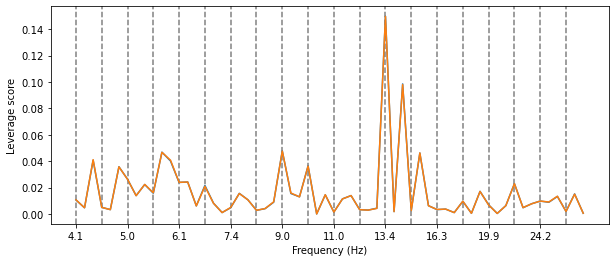

In [132]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
plt.rc("font", size=10)

ax.plot(calculate_leverage_score(V.T, average=False))
ax.plot(calculate_leverage_score(V2.T, average=False))
axplot_label_leverage_frequency(
    V, freqs, chan_idx, ax, annotate_color="k", freq_scale=2
)

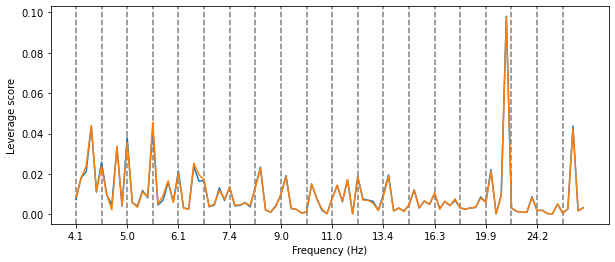

In [133]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(calculate_leverage_score(V_exo.T, average=False))
ax.plot(calculate_leverage_score(V_exo2.T, average=False))

axplot_label_leverage_frequency(
    V_exo, freqs, chan2_idx, ax, annotate_color="k", freq_scale=2
)